# QMDA Final Project

Goal here is to put uncertainty estimates on my gridded averages. Might also play around with lateral gradient problems, but not sure if I'll get to that or not.

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.path import Path
import matplotlib.colors as colors
import pandas as pd
import numpy as np
import cartopy.crs as ccrs
import cmocean.cm as cmo
import scipy.ndimage as filter
import scipy.interpolate as interpolate
from flox.xarray import xarray_reduce
from xgcm.autogenerate import generate_grid_ds
from xgcm import Grid
from tqdm import tqdm
from dask.diagnostics import ProgressBar

In [2]:
import os
os.chdir('/home.ufs/amf2288/argo-intern/funcs')
import filt_funcs as ff

In [3]:
# Set title size
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 16  # Titles larger

# Set axis label size
plt.rcParams['axes.labelsize'] = 14  # Labels slightly smaller

In [4]:
ds_p = xr.open_dataset('/swot/SUM05/amf2288/res_2.5/ds_p.nc').rename({'N_PROF':'profile','PRES_INTERPOLATED':'pressure','LATITUDE':'lat','LONGITUDE':'lon'})

In [5]:
lfilt = 100
rho_grid = np.arange(21,29,0.0025)
lon_bins = np.arange(-180,181,3)
lat_bins = np.arange(-90,91,3)

In [6]:
ct_e = xr.open_dataarray('/swot/SUM05/amf2288/var-boxes/ct_e_3.nc', chunks={'N_PROF':100000})
sa_e = xr.open_dataarray('/swot/SUM05/amf2288/var-boxes/sa_e_3.nc', chunks={'N_PROF':100000})

In [7]:
ct_e = ct_e.rename({'N_PROF':'profile','PRES_INTERPOLATED':'pressure','LATITUDE':'lat','LONGITUDE':'lon','N_PROF_NEW':'prof_new'})
sa_e = sa_e.rename({'N_PROF':'profile','PRES_INTERPOLATED':'pressure','LATITUDE':'lat','LONGITUDE':'lon','N_PROF_NEW':'prof_new'})

In [8]:
ct_m = xr.open_dataarray('/swot/SUM05/amf2288/var-boxes/ct_m_3.nc', chunks={'N_PROF':100000})
sa_m = xr.open_dataarray('/swot/SUM05/amf2288/var-boxes/sa_m_3.nc', chunks={'N_PROF':100000})

In [9]:
ct_m = ct_m.rename({'N_PROF':'profile','PRES_INTERPOLATED':'pressure','LATITUDE':'lat','LONGITUDE':'lon','N_PROF_NEW':'prof_new'})
sa_m = sa_m.rename({'N_PROF':'profile','PRES_INTERPOLATED':'pressure','LATITUDE':'lat','LONGITUDE':'lon','N_PROF_NEW':'prof_new'})

In [10]:
ct_e_z2 = ct_e.differentiate(coord='pressure')**2
sa_e_z2 = sa_e.differentiate(coord='pressure')**2

In [11]:
ct_m_z2 = ct_m.differentiate(coord='pressure')**2
sa_m_z2 = sa_m.differentiate(coord='pressure')**2

In [12]:
%%time
ct_e_z2_filt = ff.da_filt_single(ct_e_z2, lfilt, dim1='profile', dim2='pressure')
sa_e_z2_filt = ff.da_filt_single(sa_e_z2, lfilt, dim1='profile', dim2='pressure')

CPU times: user 3min 22s, sys: 1min 12s, total: 4min 35s
Wall time: 3min 44s


In [13]:
ct_e_z2_filt.name = 'ct_e_z2_filt'
ct_e_z2_filt = ct_e_z2_filt.to_dataset()

sa_e_z2_filt.name = 'sa_e_z2_filt'
sa_e_z2_filt = sa_e_z2_filt.to_dataset()

In [14]:
ct_m_z2.name = 'ct_m_z2'
ct_m_z2 = ct_m_z2.to_dataset()

sa_m_z2.name = 'sa_m_z2'
sa_m_z2 = sa_m_z2.to_dataset()

In [16]:
ct_e_z2_filt['ct_e_z2_filt_log'] = (['profile','pressure'], np.log10(ct_e_z2_filt.ct_e_z2_filt).data)
sa_e_z2_filt['sa_e_z2_filt_log'] = (['profile','pressure'], np.log10(sa_e_z2_filt.sa_e_z2_filt).data)

In [17]:
ct_m_z2['ct_m_z2_log'] = (['profile','pressure'], np.log10(ct_m_z2.ct_m_z2).data)
sa_m_z2['sa_m_z2_log'] = (['profile','pressure'], np.log10(sa_m_z2.sa_m_z2).data)

In [20]:
def get_ds_gridded(ds, lon_bins, lat_bins):
    """
    Bin profiles into lon/lat boxes and compute mean, std, and count
    for ct_e_z2_filt across pressure levels.
    """

    def reduce_with_progress(func, skipna=True, suffix=""):
        print(f"\nStarting {func} reduction...")
        with ProgressBar():  # separate progress bar for each flox call
            out = xarray_reduce(
                ds,
                'lon',        # bin by longitude
                'lat',        # bin by latitude
                func=func,
                expected_groups=(
                    pd.IntervalIndex.from_breaks(lon_bins),
                    pd.IntervalIndex.from_breaks(lat_bins)
                ),
                fill_value=np.nan,
                skipna=skipna
            ).compute()
        # Rename variable to avoid merge conflicts
        out = out.rename({var: f"{var}{suffix}" for var in out.data_vars})
        print(f"{func} reduction complete.")
        return out

    # Step 1: Compute mean, std, count
    ds_mean  = reduce_with_progress('mean',  skipna=True,  suffix="_mean")
    ds_std   = reduce_with_progress('std',   skipna=True,  suffix="_std")
    ds_count = reduce_with_progress('count', skipna=False, suffix="_count")

    # Step 2: Merge results
    ds_binned = xr.merge([ds_mean, ds_std, ds_count])

    # Step 3: Rename bin dimensions
    ds_binned = ds_binned.rename_dims({
        'lon_bins': 'lon',
        'lat_bins': 'lat'
    }).rename_vars({
        'lon_bins': 'lon',
        'lat_bins': 'lat'
    })

    # Step 4: Replace Interval coordinates with midpoints
    def interval_midpoints(intervals):
        return np.array([interval.mid for interval in intervals])

    ds_binned = ds_binned.assign_coords({
        'lon': ('lon', interval_midpoints(ds_binned['lon'].values)),
        'lat': ('lat', interval_midpoints(ds_binned['lat'].values))
    })

    # Step 5: Generate grid and xgcm object
    ds_gridded = generate_grid_ds(ds_binned, {'X': 'lon', 'Y': 'lat'})
    grid = Grid(ds_gridded, coords={
        'X': {'center': 'lon', 'left': 'lon_left'},
        'Y': {'center': 'lat', 'left': 'lat_left'},
        'Z': {'center': 'pressure'}  # keep pressure dimension
    }, periodic=['X'])

    return ds_gridded, grid

In [21]:
ct_var2, grid = get_ds_gridded(ct_e_z2_filt, lon_bins, lat_bins)


Starting mean reduction...
[########################################] | 100% Completed | 21.15 s
mean reduction complete.

Starting std reduction...
[########################################] | 100% Completed | 49.20 s
std reduction complete.

Starting count reduction...
[########################################] | 100% Completed | 8.70 s
count reduction complete.


In [22]:
sa_var2, grid = get_ds_gridded(sa_e_z2_filt, lon_bins, lat_bins)


Starting mean reduction...
[########################################] | 100% Completed | 21.45 s
mean reduction complete.

Starting std reduction...
[########################################] | 100% Completed | 47.46 s
std reduction complete.

Starting count reduction...
[########################################] | 100% Completed | 11.68 s
count reduction complete.


In [23]:
ct_var3, grid = get_ds_gridded(ct_m_z2, lon_bins, lat_bins)


Starting mean reduction...
[########################################] | 100% Completed | 40.14 s
mean reduction complete.

Starting std reduction...
[########################################] | 100% Completed | 65.09 s
std reduction complete.

Starting count reduction...
[########################################] | 100% Completed | 21.99 s
count reduction complete.


In [24]:
sa_var3, grid = get_ds_gridded(sa_m_z2, lon_bins, lat_bins)


Starting mean reduction...
[########################################] | 100% Completed | 38.09 s
mean reduction complete.

Starting std reduction...
[########################################] | 100% Completed | 68.02 s
std reduction complete.

Starting count reduction...
[########################################] | 100% Completed | 20.92 s
count reduction complete.


In [ ]:
ds_p_gridded, grid = get_ds_gridded(ds_p, lon_bins, lat_bins)

In [26]:
ct_var2

<xarray.Dataset> Size: 346MB
Dimensions:                 (pressure: 1001, lon: 120, lat: 60, lon_left: 120,
                             lat_left: 60)
Coordinates:
  * pressure                (pressure) int64 8kB 0 2 4 6 ... 1994 1996 1998 2000
  * lon                     (lon) float64 960B -178.5 -175.5 ... 175.5 178.5
  * lat                     (lat) float64 480B -88.5 -85.5 -82.5 ... 85.5 88.5
  * lon_left                (lon_left) float64 960B -180.0 -177.0 ... 177.0
  * lat_left                (lat_left) float64 480B -90.0 -87.0 ... 84.0 87.0
Data variables:
    ct_e_z2_filt_mean       (pressure, lon, lat) float64 58MB nan nan ... nan
    ct_e_z2_filt_log_mean   (pressure, lon, lat) float64 58MB nan nan ... nan
    ct_e_z2_filt_std        (pressure, lon, lat) float64 58MB nan nan ... nan
    ct_e_z2_filt_log_std    (pressure, lon, lat) float64 58MB nan nan ... nan
    ct_e_z2_filt_count      (pressure, lon, lat) float64 58MB nan nan ... nan
    ct_e_z2_filt_log_count  (pressure, lon, lat) float64 58MB nan nan ... nan

## Initial Maps

In [131]:
depth = 250

# Select one pressure level, e.g. 1000 dbar
ct2_level = ct_var2.sel(pressure=depth)
sa2_level = sa_var2.sel(pressure=depth)

# Standard error of the mean
ct2_sem = ct2_level.ct_e_z2_filt_log_std #/ np.sqrt(ct2_level.ct_e_z2_filt_count)
sa2_sem = sa2_level.sa_e_z2_filt_log_std #/ np.sqrt(sa2_level.sa_e_z2_filt_count)

# 95% CI bounds
ct2_lower = ct2_level.ct_e_z2_filt_log_mean - 2 * ct2_sem
ct2_upper = ct2_level.ct_e_z2_filt_log_mean + 2 * ct2_sem
ct2_ci_width = ct2_upper - ct2_lower

sa2_lower = sa2_level.sa_e_z2_filt_log_mean - 2 * sa2_sem
sa2_upper = sa2_level.sa_e_z2_filt_log_mean + 2 * sa2_sem
sa2_ci_width = sa2_upper - sa2_lower

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(15, 8), subplot_kw={'projection': ccrs.PlateCarree()})

vmin=-7
vmax=-4

ax = axs[0, 0]
ct2_level.ct_e_z2_filt_log_mean.plot(ax=ax, x='lon', y='lat', transform=ccrs.PlateCarree(), cmap=cmo.balance, 
                                     vmin=vmin, vmax=vmax, cbar_kwargs={'label':'Mesoscale Variance (log scale)'})
ax.coastlines()
gl = ax.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False
ax.set_title(f"Mesoscale Temperature Variance \n Mean Field, depth={depth} m")

ax = axs[0, 1]
ct2_ci_width.plot(ax=ax, x='lon', y='lat', transform=ccrs.PlateCarree(), cmap=cmo.amp,
                  vmin=0, vmax=2, cbar_kwargs={'label':'Confidence Interval Width (log scale)'})
ax.coastlines()
gl = ax.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False
ax.set_title(f"Mesoscale Temperature Variance \n Confidence Interval Width, depth={depth} m")

ax = axs[1, 0]
ct2_lower.plot(ax=ax, x='lon', y='lat', transform=ccrs.PlateCarree(), cmap=cmo.balance,
               vmin=vmin, vmax=vmax, cbar_kwargs={'label':'Mesoscale Variance (log scale)'})
ax.coastlines()
gl = ax.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False
ax.set_title(f"Mesoscale Temperature Variance \n 5% Value, depth={depth} m")

ax = axs[1, 1]
ct2_upper.plot(ax=ax, x='lon', y='lat', transform=ccrs.PlateCarree(), cmap=cmo.balance,
               vmin=vmin, vmax=vmax, cbar_kwargs={'label':'Mesoscale Variance (log scale)'})
ax.coastlines()
gl = ax.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False
ax.set_title(f"Mesoscale Temperature Variance \n 95% Value, depth={depth} m")

plt.tight_layout()
plt.show()

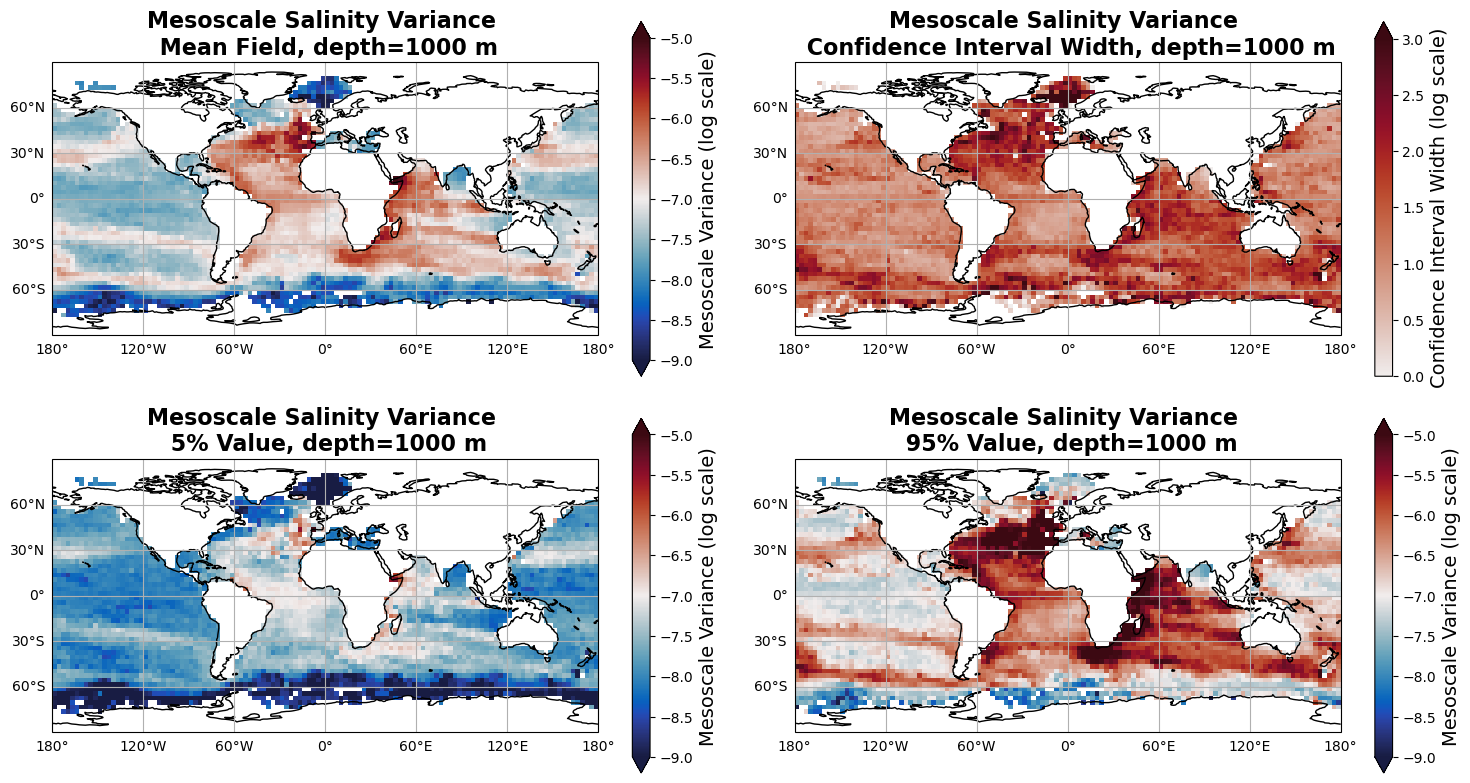

In [107]:
fig, axs = plt.subplots(2, 2, figsize=(15, 8), subplot_kw={'projection': ccrs.PlateCarree()})

vmin=-9
vmax=-5

ax = axs[0, 0]
sa2_level.sa_e_z2_filt_log_mean.plot(ax=ax, x='lon', y='lat', transform=ccrs.PlateCarree(), cmap=cmo.balance, 
                                     vmin=vmin, vmax=vmax, cbar_kwargs={'label':'Mesoscale Variance (log scale)'})
ax.coastlines()
gl = ax.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False
ax.set_title(f"Mesoscale Salinity Variance \n Mean Field, depth={depth} m")

ax = axs[0, 1]
sa2_ci_width.plot(ax=ax, x='lon', y='lat', transform=ccrs.PlateCarree(), cmap=cmo.amp,
                  vmin=0, vmax=3, cbar_kwargs={'label':'Confidence Interval Width (log scale)'})
ax.coastlines()
gl = ax.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False
ax.set_title(f"Mesoscale Salinity Variance \n Confidence Interval Width, depth={depth} m")

ax = axs[1, 0]
sa2_lower.plot(ax=ax, x='lon', y='lat', transform=ccrs.PlateCarree(), cmap=cmo.balance,
               vmin=vmin, vmax=vmax, cbar_kwargs={'label':'Mesoscale Variance (log scale)'})
ax.coastlines()
gl = ax.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False
ax.set_title(f"Mesoscale Salinity Variance \n 5% Value, depth={depth} m")

ax = axs[1, 1]
sa2_upper.plot(ax=ax, x='lon', y='lat', transform=ccrs.PlateCarree(), cmap=cmo.balance,
               vmin=vmin, vmax=vmax, cbar_kwargs={'label':'Mesoscale Variance (log scale)'})
ax.coastlines()
gl = ax.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False
ax.set_title(f"Mesoscale Salinity Variance \n 95% Value, depth={depth} m")

plt.tight_layout()
plt.show()

## Confidence Intervals for One Box

In [35]:
lon_up = -24
lon_lo = -27
lon_mid = 0.5*(lon_up - lon_lo) + lon_lo

lat_up = 42
lat_lo = 39
lat_mid = 0.5*(lat_up - lat_lo) + lat_lo

In [48]:
lat_mask = ((ct_e_z2_filt.lat < lat_up) & (ct_e_z2_filt.lat > lat_lo)).compute()
lon_mask = ((ct_e_z2_filt.lon < lon_up) & (ct_e_z2_filt.lon > lon_lo)).compute()

In [49]:
profs_ct_var2 = ct_e_z2_filt.where(lat_mask & lon_mask, drop=True).sortby('lat').ct_e_z2_filt_log
profs_sa_var2 = sa_e_z2_filt.where(lat_mask & lon_mask, drop=True).sortby('lat').sa_e_z2_filt_log

In [110]:
# Select one pressure level, e.g. 1000 dbar
box_ct_var2 = ct_var2.sel(lon=lon_mid, lat=lat_mid)
box_sa_var2 = sa_var2.sel(lon=lon_mid, lat=lat_mid)

# Mean profile
mean_ct_var2 = box_ct_var2.ct_e_z2_filt_log_mean
mean_sa_var2 = box_sa_var2.sa_e_z2_filt_log_mean

# Standard error of the mean
ct2_sem = box_ct_var2.ct_e_z2_filt_log_std #/ np.sqrt(box_ct_var2.ct_e_z2_filt_count)
sa2_sem = box_sa_var2.sa_e_z2_filt_log_std #/ np.sqrt(box_sa_var2.sa_e_z2_filt_count)

# 95% CI bounds
ct2_lower = mean_ct_var2 - 2 * ct2_sem
ct2_upper = mean_ct_var2 + 2 * ct2_sem
ct2_ci_width = ct2_upper - ct2_lower

sa2_lower = mean_sa_var2 - 2 * sa2_sem
sa2_upper = mean_sa_var2 + 2 * sa2_sem
sa2_ci_width = sa2_upper - sa2_lower

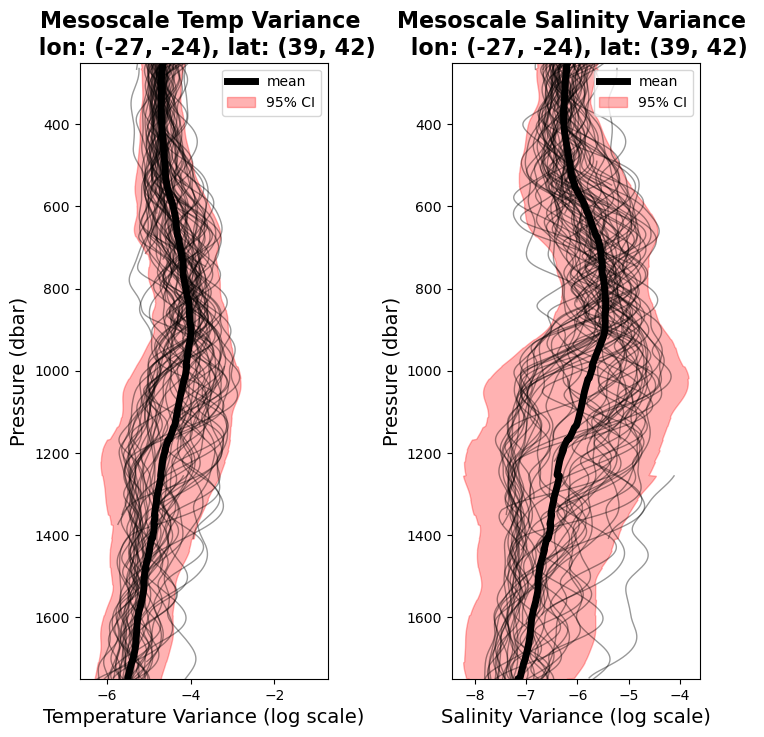

In [117]:
plt.figure(figsize=(8,8))

plt.subplot(121)
for n in range(0, len(profs_ct_var2)):
    profs_ct_var2.isel(profile=n).plot(y='pressure', color='k', alpha=0.4, linewidth=1)
mean_ct_var2.plot(y='pressure', color='k', linewidth=5, label='mean')
plt.fill_betweenx(ct2_lower['pressure'], ct2_lower.values, ct2_upper.values, color='r', alpha=0.3, label='95% CI')
plt.legend()
plt.ylim(1750, 250)
plt.ylabel('Pressure (dbar)')
plt.xlabel('Temperature Variance (log scale)')
plt.title(f'Mesoscale Temp Variance \n lon: ({lon_lo}, {lon_up}), lat: ({lat_lo}, {lat_up})')

plt.subplot(122)
for n in range(0, len(profs_ct_var2)):
    profs_sa_var2.isel(profile=n).plot(y='pressure', color='k', alpha=0.4, linewidth=1)
mean_sa_var2.plot(y='pressure', color='k', linewidth=5, label='mean')
plt.fill_betweenx(sa2_lower['pressure'], sa2_lower.values, sa2_upper.values, color='r', alpha=0.3, label='95% CI')
plt.legend()
plt.ylim(1750, 250)
plt.ylabel('Pressure (dbar)')
plt.xlabel('Salinity Variance (log scale)')
plt.title(f'Mesoscale Salinity Variance \n lon: ({lon_lo}, {lon_up}), lat: ({lat_lo}, {lat_up})')

plt.subplots_adjust(wspace=0.5)

plt.show()

## Zonal Integrals

In [ ]:
# --- Step 1: Compute zonal mean across longitude ---
ct2_zonal_mean  = ct_var2.ct_e_z2_filt_log_mean.mean(dim=["lon", 'pressure'])
ct2_zonal_std   = ct_var2.ct_e_z2_filt_log_std.mean(dim=["lon", 'pressure'])
ct2_zonal_count = ct_var2.ct_e_z2_filt_log_count.mean(dim=["lon", 'pressure'])

# --- Step 2: Standard error of zonal mean ---
ct2_zonal_sem = ct2_zonal_std #/ np.sqrt(ct2_zonal_count)

# --- Step 3: 95% CI bounds ---
ct2_zonal_lower = ct2_zonal_mean - 2 * ct2_zonal_sem
ct2_zonal_upper = ct2_zonal_mean + 2 * ct2_zonal_sem

In [ ]:
# --- Step 1: Compute zonal mean across longitude ---
sa2_zonal_mean  = sa_var2.sa_e_z2_filt_log_mean.mean(dim=["lon", 'pressure'])
sa2_zonal_std   = sa_var2.sa_e_z2_filt_log_std.mean(dim=["lon", 'pressure'])
sa2_zonal_count = sa_var2.sa_e_z2_filt_log_count.mean(dim=["lon", 'pressure'])

# --- Step 2: Standard error of zonal mean ---
sa2_zonal_sem = sa2_zonal_std #/ np.sqrt(sa2_zonal_count)

# --- Step 3: 95% CI bounds ---
sa2_zonal_lower = sa2_zonal_mean - 2 * sa2_zonal_sem
sa2_zonal_upper = sa2_zonal_mean + 2 * sa2_zonal_sem

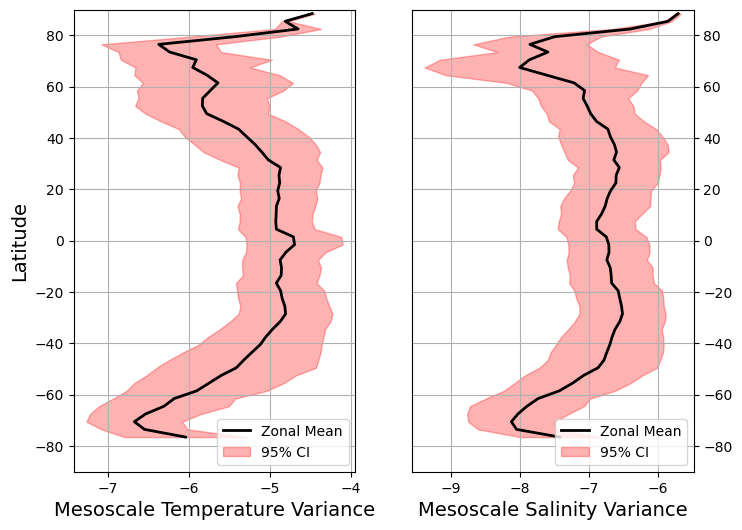

In [130]:
plt.figure(figsize=(8,6))

plt.subplot(121)
plt.plot(ct2_zonal_mean, ct2_zonal_mean['lat'], color='k', linewidth=2, label='Zonal Mean')
plt.fill_betweenx(ct2_zonal_mean['lat'], ct2_zonal_lower, ct2_zonal_upper,
                  color='red', alpha=0.3, label='95% CI')
plt.ylabel("Latitude")
plt.ylim(-90,90)
plt.xlabel("Mesoscale Temperature Variance")
plt.legend(loc='lower right')
plt.grid(True)

plt.subplot(122)
plt.plot(sa2_zonal_mean, sa2_zonal_mean['lat'], color='k', linewidth=2, label='Zonal Mean')
plt.fill_betweenx(sa2_zonal_mean['lat'], sa2_zonal_lower, sa2_zonal_upper,
                  color='red', alpha=0.3, label='95% CI')
plt.ylim(-90,90)
plt.xlabel("Mesoscale Salinity Variance")
plt.legend(loc='lower right')
plt.grid(True)

# Move y-axis ticks + labels to the right
ax = plt.gca()
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")

plt.show()

## Intro Slide

In [47]:
plt.figure(figsize=(10,5))
# Count non-NaN values along pressure for each profile
valid_counts = profs_ct.count(dim="pressure")

# Select only profiles with >100 valid values
filtered = profs_ct.sel(profile=valid_counts.where(valid_counts > 750, drop=True).profile)
n_profiles = len(filtered.profile)
filtered = filtered.assign_coords(N_PROF_NEW=("profile", np.arange(n_profiles)))

filtered.sortby('N_PROF_NEW').plot(x='N_PROF_NEW',y='pressure',cmap=cmo.thermal, vmin=5, vmax=15, cbar_kwargs={'label':'Temperature (C)'})
plt.ylim(1750,250)
plt.ylabel('Pressure (dbar)')
plt.xlabel('Profile');

NameError: name 'profs_ct' is not defined

<Figure size 1000x500 with 0 Axes>

In [ ]:
plt.figure(figsize=(10,5))
# Count non-NaN values along pressure for each profile
valid_counts = profs_sa.count(dim="pressure")

# Select only profiles with >100 valid values
filtered = profs_sa.sel(profile=valid_counts.where(valid_counts > 750, drop=True).profile)
n_profiles = len(filtered.profile)
filtered = filtered.assign_coords(N_PROF_NEW=("profile", np.arange(n_profiles)))

filtered.sortby('N_PROF_NEW').plot(x='N_PROF_NEW',y='pressure',cmap=cmo.haline, vmin=35.2, vmax=35.8, cbar_kwargs={'label':'Salinity (g/kg)'})
plt.ylim(1750,250)
plt.ylabel('Pressure (dbar)')
plt.xlabel('Profile');

In [ ]:
profs_sig0 = ds_p.SIG0.where(lat_mask & lon_mask, drop=True).sortby('lat')
plt.figure(figsize=(10,5))
# Count non-NaN values along pressure for each profile
valid_counts = profs_sig0.count(dim="pressure")

# Select only profiles with >100 valid values
filtered = profs_sig0.sel(profile=valid_counts.where(valid_counts > 750, drop=True).profile)
n_profiles = len(filtered.profile)
filtered = filtered.assign_coords(N_PROF_NEW=("profile", np.arange(n_profiles)))

filtered.sortby('N_PROF_NEW').plot(x='N_PROF_NEW',y='pressure',cmap=cmo.dense, vmin=27, vmax=27.75, cbar_kwargs={'label':'Density (kg/m3)'})
plt.ylim(1750,250)
plt.ylabel('Pressure (dbar)')
plt.xlabel('Profile');

In [ ]:
profs_sp = ds_p.SPICE.where(lat_mask & lon_mask, drop=True).sortby('lat')
plt.figure(figsize=(10,5))
# Count non-NaN values along pressure for each profile
valid_counts = profs_sp.count(dim="pressure")

# Select only profiles with >100 valid values
filtered = profs_sp.sel(profile=valid_counts.where(valid_counts > 750, drop=True).profile)
n_profiles = len(filtered.profile)
filtered = filtered.assign_coords(N_PROF_NEW=("profile", np.arange(n_profiles)))

filtered.sortby('N_PROF_NEW').plot(x='N_PROF_NEW',y='pressure',cmap=cmo.matter, vmin=0.5, vmax=2.75, cbar_kwargs={'label':'Spice'})
plt.ylim(1750,250)
plt.ylabel('Pressure (dbar)')
plt.xlabel('Profile');

In [ ]:
fig, axs = plt.subplots(1, 1, figsize=(10, 4), subplot_kw={'projection': ccrs.PlateCarree()})
ds_p_grid3.CT.sel(pressure=100).plot(x='lon',y='lat', transform=ccrs.PlateCarree(), cmap=cmo.thermal, vmin=2, vmax=20, cbar_kwargs={'label':'Temperature (C)'})
axs.coastlines()
gl1 = axs.gridlines(draw_labels=True)
gl1.top_labels = False
gl1.right_labels = False
axs.set_global()
plt.title('')

plt.subplots_adjust(wspace=0.05)

In [ ]:
fig, axs = plt.subplots(1, 1, figsize=(10, 4), subplot_kw={'projection': ccrs.PlateCarree()})
ds_p_grid3.CT.sel(pressure=500).plot(x='lon',y='lat', transform=ccrs.PlateCarree(), cmap=cmo.thermal, vmin=2, vmax=20, cbar_kwargs={'label':'Temperature (C)'})
axs.coastlines()
gl1 = axs.gridlines(draw_labels=True)
gl1.top_labels = False
gl1.right_labels = False
axs.set_global()
plt.title('')

plt.subplots_adjust(wspace=0.05)

In [ ]:
fig, axs = plt.subplots(1, 1, figsize=(10, 4), subplot_kw={'projection': ccrs.PlateCarree()})
ds_p_grid3.CT.sel(pressure=1000).plot(x='lon',y='lat', transform=ccrs.PlateCarree(), cmap=cmo.thermal, vmin=2, vmax=20, cbar_kwargs={'label':'Temperature (C)'})
axs.coastlines()
gl1 = axs.gridlines(draw_labels=True)
gl1.top_labels = False
gl1.right_labels = False
axs.set_global()
plt.title('')

plt.subplots_adjust(wspace=0.05)

In [ ]:
fig, axs = plt.subplots(1, 1, figsize=(10, 4), subplot_kw={'projection': ccrs.PlateCarree()})
ds_p_grid3.CT.sel(pressure=1500).plot(x='lon',y='lat', transform=ccrs.PlateCarree(), cmap=cmo.thermal, vmin=2, vmax=20, cbar_kwargs={'label':'Temperature (C)'})
axs.coastlines()
gl1 = axs.gridlines(draw_labels=True)
gl1.top_labels = False
gl1.right_labels = False
axs.set_global()
plt.title('')

plt.subplots_adjust(wspace=0.05)